**This notebook contains the Pytorch implementation of DCGAN on Fashion MNIST dataset .Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.**

**The original MNIST dataset contains a lot of handwritten digits. I also applied DCGAN on that dataset due to redundancy i'm not going to upload that notebook.I will share result in Readme.md**

In [0]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F 
import torchvision 
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
from torch import optim as opt
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


**1. Simply downloading the FashionMNIST dataset with the help of Pytorch default setting provided in the dataset library , which is actually the second portion of the code.** 

**2. Then transforming the dataset into pytorch tensor data type so we can utilize the GPU.**

In [0]:

transform= transforms.Compose([
                 # transforms.CenterCrop(128),
                  # transforms.Scale(64),
                   transforms.ToTensor(),
                   transforms.Normalize((.5,),(.5,))
    
    
                   ])
dataset=datasets.FashionMNIST(
            root="./FashionMNIST/",
            download=True,
            train=True,
            transform=transform 
          )




**Creating mini batches for training of size 64** 

In [32]:
dataloader=torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=64,num_workers=2)
dataiter=iter(dataloader)
imgs,_=next(dataiter)
print(imgs.size())


torch.Size([64, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 242, 242])


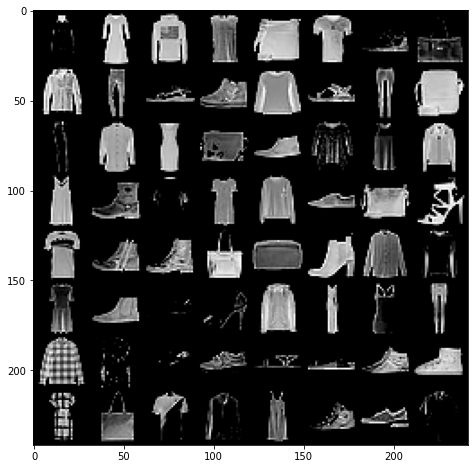

In [33]:
def imshow(imgs):
    imgs=torchvision.utils.make_grid(imgs)
    print(imgs.size())
    npimg=imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(imgs,(1,2,0)))
    
imshow(imgs)

In [0]:
bs=64,
Z=100


**Defining the initial weight for convolution layer and Batch normalization layer** 

In [0]:
def weight(m):
    classname=m.__class__.__name__
    if classname.find("Conv")!=-1:
        nn.init.normal_(m.weight.data,0,0.02)
    if classname.find("BatchNorm")!=-1:
        nn.init.normal_(m.weight.data,1,.02)
        nn.init.normal_(m.bias.data,0)

In [0]:
def to_var(x):
    if torch.cuda.is_available():#utilize the gpu of the pc
        x = x.cuda()
    return Variable(x)

def denorm(x): #It used to restrict a value to a given range.
    out = (x + 1) / 2
    return out.clamp(0, 1)

**Defining the generetor architecture**

In [0]:
class genretor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
                  
                  nn.ConvTranspose2d(100,512,4,1,0,bias=False),
                  nn.BatchNorm2d(512),
                  nn.ReLU(True),
                  nn.ConvTranspose2d(512,256,4,2,1,bias=False),
                  nn.BatchNorm2d(256),
                  nn.ReLU(True),
                  nn.ConvTranspose2d(256,128,4,2,1,bias=False),
                  nn.BatchNorm2d(128),
                  nn.ReLU(True),
                  nn.ConvTranspose2d(128,1,4,2,3,bias=False),
                  nn.Tanh()
         )
           
    def forward(self,input):
        return self.model(input)
        

   

In [38]:
G=genretor()
G.apply(weight)
noise=torch.randn(64,100,1,1)
print(G(noise).size())
print(G)

torch.Size([64, 1, 28, 28])
genretor(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)


**Defining the Discriminator architecture**

In [0]:
class dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
                nn.Conv2d(1,128,4,2,1,bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(.2),
                nn.Conv2d(128,256,4,2,1,bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(.2),
                nn.Conv2d(256,512,3,2,1,bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(.2),
                nn.Conv2d(512,1,4,1,0,bias=False),
                nn.Sigmoid()
            
            )
           
    def forward(self,input):
        return self.model(input)

        

In [40]:
D=dis()
D.apply(weight)
print(D(imgs).view(-1).size())
print(D)
print(to_var(torch.ones(bs)).size())

torch.Size([64])
dis(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)
torch.Size([64])


In [0]:
if torch.cuda.is_available():
    D.cuda()
    G.cuda()

In [0]:
beta1=.5
optimizer_D=opt.Adam(D.parameters(),lr=.0002,betas=(beta1, 0.999))
optimizer_G=opt.Adam(G.parameters(),lr=.0002,betas=(beta1, 0.999))
criterion = nn.BCELoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch=0,G_loss=2.2766793035685633,D_loss=0.7741277207062442,time=1.2511957208315532min
torch.Size([3, 122, 242])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch=10,G_loss=2.7105994190552085,D_loss=0.6017565075586091,time=13.857672274112701min
torch.Size([3, 122, 242])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch=20,G_loss=3.357973297998341,D_loss=0.4673035421224037,time=26.471017515659334min
torch.Size([3, 122, 242])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch=30,G_loss=3.8420555867683657,D_loss=0.3673918239915295,time=39.074722743034364min
torch.Size([3, 122, 242])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch=40,G_loss=4.272154290221139,D_loss=0.33804779567682286,time=51.68387341101964min
torch.Size([3, 122, 242])


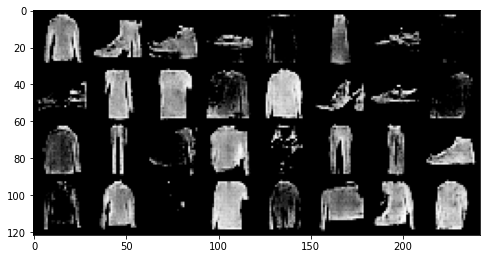

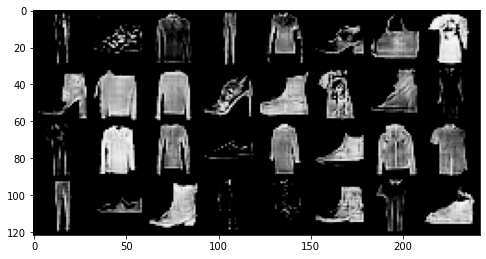

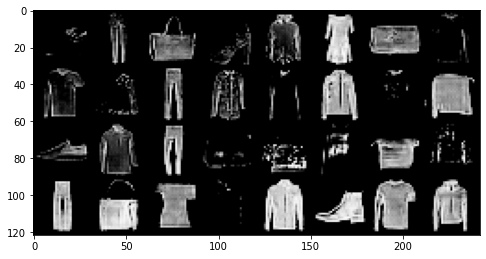

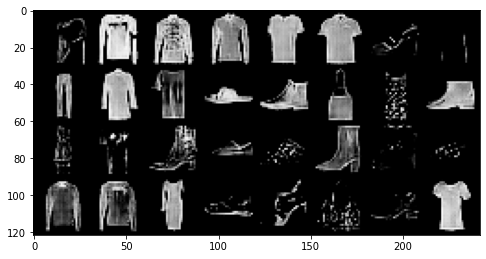

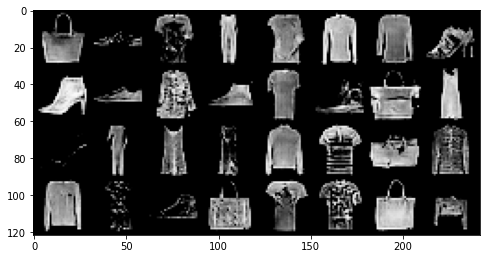

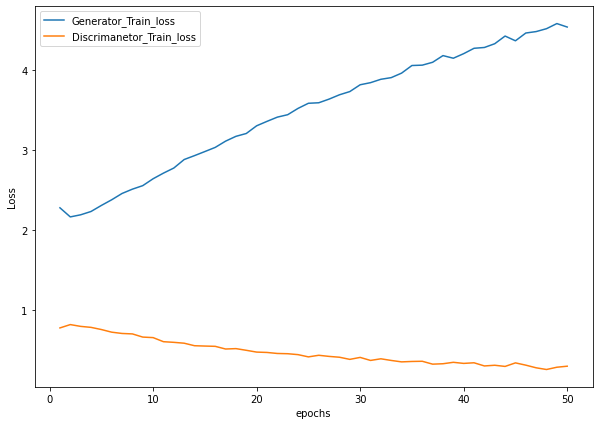

<Figure size 432x288 with 0 Axes>

In [45]:
from torchvision.utils import save_image
import time 
g_progress=[]
d_progress=[]
c=0
time_begin=time.time()
for epoch in range(50):
    G_loss_run=0
    D_loss_run=0
    for i,(images,_) in enumerate(dataloader):
              
              bs=images.size(0)
              
              
              images=to_var(images)
              z=to_var(torch.randn(bs,100,1,1))
              real_label=to_var(torch.ones(bs))
              fake_label=to_var(torch.zeros(bs))
              if torch.cuda.is_available():
                  D.cuda()
                  G.cuda()
      
              D.zero_grad()
            
              D_real=D(images).view(-1)
              D_real_loss=criterion(D_real,real_label)
              D_real_loss.backward()
              D_x = D_real.mean().item()
              
              fake=G(z)
              
              z=to_var(torch.randn(bs,100,1,1))
              D_fake=D(fake.detach()).view(-1)
              D_fake_loss=criterion(D_fake,fake_label)
              D_fake_loss.backward()
              D_G_z1 = D_real.mean().item()
              
              D_loss=D_real_loss+D_fake_loss
              
              optimizer_D.step()

              G.zero_grad()
              
              
              D_fake=D(fake).view(-1)
              G_loss=criterion(D_fake,real_label)
              
              
              G_loss.backward()
              optimizer_G.step()

              G_loss_run +=G_loss.item()
              D_loss_run +=D_loss.item()
  
    g_progress.append(G_loss_run/(i+1))
    d_progress.append(D_loss_run/(i+1))
    if epoch%10==0:
      time_end=time.time()
      print("Epoch={},G_loss={},D_loss={},time={}min".format(epoch,G_loss_run/(i+1),D_loss_run/(i+1),((time_end-time_begin)/60)))

    sample=G(z).detach() 
    sample=sample.cpu()
    sample=sample.view(sample.size(0),1,28,28)

    if epoch%10==0:
      imshow(sample)
    c=c+1
    save_image(sample,"./dcgan/"+str(c)+".png")

fig,ax=plt.subplots(figsize=(10,7))
ax.plot(np.arange(1, 51, 1),np.asarray(g_progress), label='Generator_Train_loss')
ax.set_xlabel("epochs")
ax.set_ylabel("Loss")
ax.plot(np.arange(1, 51, 1),np.asarray(d_progress), label='Discrimanetor_Train_loss')
ax.legend()
plt.show()
plt.savefig('Fashion_MNIST_GAN_loss.png')   
